## MCX simulation

In [2]:
! pip install pmcx
! git clone --recursive https://github.com/fangq/mcx.git
!pip install numpy pmcx jdata bjdata matplotlib
import pmcx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.7 MB/s eta 0:00:00
Cloning into 'mcx'...
remote: Enumerating objects: 13205, done.
remote: Counting objects: 100% (2745/2745), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 13205 (delta 2583), reused 2509 (delta 2508), pack-reused 10460 (from 3)
Receiving objects: 100% (13205/13205), 25.16 MiB | 29.24 MiB/s, done.
Resolving deltas: 100% (9196/9196), done.
Submodule 'filter' (https://github.com/fangq/GPU-ANLM.git) registered for path 'filter'
Submodule 'src/pybind11' (https://github.com/pybind/pybind11.git) registered for path 'src/pybind11'
Cloning into '/content/mcx/filter'...
remote: Enumerating objects: 117, done.        
remote: Counting objects: 100% (10/10), done.        
remote: Compressing objects: 100% (8/8), done.        
remote: Total 117 (delta 4), reused 4 (delta 2), pack-reused 107 (from 1)        
Receiving objects: 100% (117/117), 3.66 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (59/5

In [3]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### Define Layer Properties

In [4]:
# Define GT tissue properties. [HHB, HBO, CCO]
wl = 890 #wavelength in nm.

# skin layer
HbO2_skin = 60;
Hb_skin = 25;
CCO_skin = 8.5;
a_skin = 17.0;
b_skin = 0.7;
g_skin = 0.85;

# scalp layer
HbO2_scalp = 65;
Hb_scalp = 30;
CCO_scalp = 9;
a_scalp = 17.0;
b_scalp = 0.7;
g_scalp = 0.85;

# skull layer
HbO2_skull = 55;
Hb_skull = 20;
CCO_skull = 8;
a_skull = 17.0;
b_skull = 0.7;
g_skull = 0.85;

# brain layer
HbO2_brain = 70;
Hb_brain = 25;
CCO_brain = 7;
a_brain = 17.0;
b_brain = 0.7;
g_brain = 0.85;

### Connect to the google drive & read coefficient

In [5]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pmcx
import jdata as jd
from matplotlib import pyplot as plt

Mounted at /content/drive


In [6]:
coe_path = '/content/drive/MyDrive/MCX_data/EC.xlsx'
data = pd.read_excel(coe_path)

# Define target wavelength
wl = 690  # nm

# Extract wavelength column
lambda_values = data['Lambda'].values

# Find index of the wavelength closest to 690 nm
idx = np.argmin(np.abs(lambda_values - wl))

# Extract extinction coefficients
HbO2_coef = data.loc[idx, 'HbO2']
Hb_coef   = data.loc[idx, 'Hb']
CCO_coef  = data.loc[idx, 'CCO']

print(f'Extinction Coefficients at {wl} nm:')
print(f'  HbO2: {HbO2_coef:.4f} cm^-1/(μmol/L)')
print(f'  Hb:   {Hb_coef:.4f} cm^-1/(μmol/L)')
print(f'  CCO:  {CCO_coef:.4f} cm^-1/(μmol/L)')

Extinction Coefficients at 690 nm:
  HbO2: 312.2200 cm^-1/(μmol/L)
  Hb:   2137.6400 cm^-1/(μmol/L)
  CCO:  2632.1300 cm^-1/(μmol/L)


In [7]:
def compute_mu_a(E, C):
    """
    Computes absorption coefficients (μa) from extinction coefficients and concentrations.

    Parameters:
    E : array_like, shape (3,)
        Extinction coefficients [HbO2, Hb, CCO] in cm^-1/(μmol/L)
    C : array_like, shape (n_layers, 3)
        Concentration matrix (μmol/L), one row per layer

    Returns:
    mu_a : ndarray, shape (n_layers,)
        Absorption coefficients [1/cm] for each layer
    """
    C = np.array(C) / 1e6  # Convert from μmol/L to mol/L
    E = np.array(E)        # Ensure E is an array
    mu_a = np.dot(C, E.T)  # Matrix multiplication

    return mu_a


def compute_mu_s(a_list, b_list, g_list, wl):
    """
    Computes μs for each layer from a, b, and g using:
    μs = μs' / (1 - g), where μs' = a * (λ / λ0)^(-b)

    Parameters:
    a_list : array_like
        List of 'a' scattering coefficients per layer
    b_list : array_like
        List of 'b' scattering exponents per layer
    g_list : array_like
        List of anisotropy factors per layer
    wl : float
        Wavelength in nm (e.g., 690)

    Returns:
    mu_s : ndarray
        Scattering coefficients [1/cm] for each layer
    """
    a_list = np.array(a_list)
    b_list = np.array(b_list)
    g_list = np.array(g_list)

    lambda0 = 500  # reference wavelength in nm
    mus_prime = a_list * (wl / lambda0) ** (-b_list)
    mu_s = mus_prime / (1 - g_list)
    print(mus_prime)
    return mu_s


In [8]:
E = [HbO2_coef, Hb_coef, CCO_coef]
C = [[HbO2_skin, Hb_skin, CCO_skin],
     [HbO2_scalp, Hb_scalp, CCO_scalp],
     [HbO2_skull, Hb_skull, CCO_skull],
     [HbO2_brain, Hb_brain, CCO_brain]]

a_list = [a_skin, a_scalp, a_skull , a_brain]
b_list = [b_skin, b_scalp, b_skull , b_brain]
g_list = [g_skin, g_scalp, g_skull , g_brain]


# double check us data!
mu_s = compute_mu_s(a_list, b_list, g_list, wl);
mu_a = compute_mu_a(E, C)

# transfer into mm-1
mu_a = mu_a * 0.1     # cm⁻¹ → mm⁻¹
mu_s = mu_s * 0.1     # cm⁻¹ → mm⁻¹
print('mu_a = ', mu_a, 'mu_s=', mu_s, 'g=', g_list)

[13.5685538 13.5685538 13.5685538 13.5685538]
mu_a =  [0.00945473 0.01081127 0.00809819 0.00937213] mu_s= [9.04570253 9.04570253 9.04570253 9.04570253] g= [0.85, 0.85, 0.85, 0.85]


### MCX Simulation

In [9]:
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:
#  prop=np.array([[0, 0, 1, 1], [0.005, 1, 0.01, 1.37]])) : [μa=0.005, μs=1, g=0.01, n=1.37]

vol = np.ones([100, 100, 200], dtype='uint8')
vol[:, :, 0:1] = 0    # Medium 1: Skin (2 mm, z=0 to 1)
vol[:, :, 1:2] = 1    # Medium 1: Skin (2 mm, z=0 to 1)
vol[:, :, 2:5] = 2    # Medium 2: Scalp (3 mm, z=2 to 4)
vol[:, :, 5:14] = 3   # Medium 3: Skull (7 mm, z=5 to 11)
#vol[:, :, 12:14] = 4  # Medium 4: CSF (2 mm, z=12 to 13)
vol[:, :, 14:200] = 4 # Medium 5: Brain (186 mm, z=14 to 199)

# define the boundary:
vol[:, :, 0] = 0
vol[:, :, 199] = 0
vol[0, :, :] = 0
vol[99, :, :] = 0
vol[:, 0, :] = 0
vol[:, 99, :] = 0

# set n =1.37 for tissue
prop = np.array([
    [0.0, 0.0, 1.0, 1.0],
    [mu_a[0], mu_s[0], g_list[0], 1.37],   # material 1 : skin
    [mu_a[1], mu_s[1], g_list[1], 1.37],    # material 2 : scalp
    [mu_a[2], mu_s[2], g_list[2], 1.40],   # material 3 : skull
    [mu_a[3], mu_s[3], g_list[3], 1.36],      # material 4 : brain
])

import pmcx
import numpy as np

# Simulation configuration
cfg = {
    'nphoton': 1000000,  # 1M photons
    'vol': vol, # 100x100x100 mm in size.
    'tstart': 0, # start time
    'tend': 1e-8, # end time
    'tstep': 1e-8, # step size
    'srcpos': [50, 50, 1],
    'srcdir': [0, 0, 1],  # Pointing toward z=1
    'prop': prop,  # mediums.
    'detpos': [[65, 50, 0, 5]],  # Single detector radius 5 mm, 1.5 cm far away from the light source.
    'savedetflag': 'dpxsvmw',  # Save detector ID, exit position, exit direction, partial path lengths
    'unitinmm': 1,
    'autopilot': 1,
    'debuglevel': 'DP', # Debug detected photons
    'srctype': 'gaussian',      # Gaussian spatial profile
    'waist': 1.0,                # Beam waist (1/e^2 radius) in mm
}

cfg['issaveref']=1
cfg['issavedet']=1
cfg['issrcfrom0']=1
cfg['maxdetphoton']=1000000

# Run the simulation
res = pmcx.mcxlab(cfg)
print(res['stat'])
print("Result keys:", list(res.keys()))
print('detp keys:', res['detp'].keys())

# Check for detected photon data
if 'detp' in res and res['detp'] is not None:
    detphoton = res['detp']

    # Check if any photons were detected
    if detphoton['detid'].size > 0:
        det_id = detphoton['detid']  # Detector IDs (1D: (N_photons,))
        exit_pos = detphoton['p']  # Exit positions (2D: (N_photons, 3))
        exit_dir = detphoton['v']  # Exit directions (2D: (N_photons, 3))
        ppath = detphoton.get('ppath', None)  # Partial path lengths (2D: (N_photons, N_media))

        # Print shapes of arrays
        print(f"Detector ID shape: {det_id.shape}")
        print(f"Exit positions shape: {exit_pos.shape}")
        print(f"Exit directions shape: {exit_dir.shape}")
        if ppath is not None:
            print(f"Partial path lengths shape: {ppath.shape}")
        # Inspect data field
        if 'data' in detphoton:
            data = detphoton['data']
            print(f"Data field shape: {data.shape}")
        n_photons = det_id.shape[0]
        print(f"Number of detected photons: {n_photons}")
    else:
        print("No photons detected (detid is empty).")

nphoton: 1e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
{'runtime': 535, 'nphoton': 1000000, 'energytot': 1000000.0, 'energyabs': 327284.0240743385, 'normalizer': 100.0, 'unitinmm': 1.0, 'workload': [6912.0]}
Result keys: ['detp', 'dref', 'flux', 'stat']
detp keys: dict_keys(['detid', 'nscat', 'ppath', 'mom', 'p', 'v', 'w0', 'prop', 'unitinmm', 'data'])
Detector ID shape: (7778,)
Exit positions shape: (7778, 3)
Exit directions shape: (7778, 3)
Partial path lengths shape: (7778, 4)
Data field shape: (20, 7778)
Number of detected photons: 7778


In [11]:
res['detp']['ppath'].shape

(7778, 4)

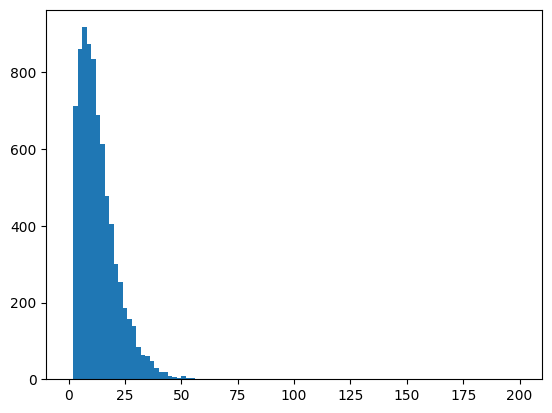

In [12]:
plt.hist(res['detp']['ppath'][:,0], bins=100, range=[0,200]); # path in first layer!

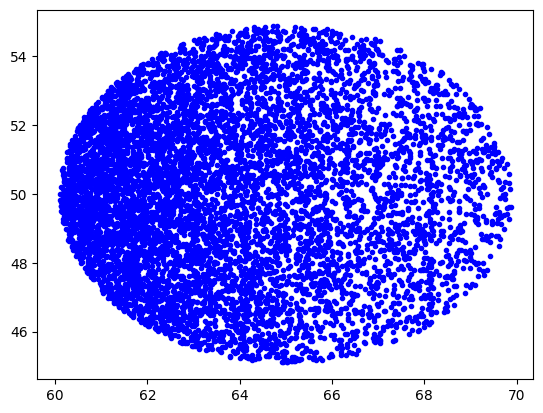

In [13]:
plt.scatter(res['detp']['p'][res['detp']['detid']==1,0], res['detp']['p'][res['detp']['detid']==1,1],
            marker='.',color='blue');

<ipython-input-14-9d62e18d193d>:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(res['dref'][:, :, 0]))


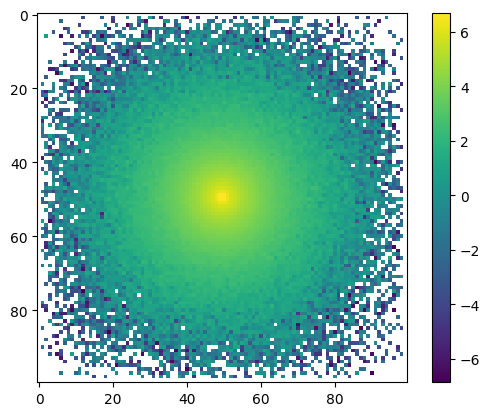

In [14]:
#print(np.log10(res['dref'][:, :, 0]).shape)
plt.imshow(np.log10(res['dref'][:, :, 0]))
plt.colorbar()
plt.show()

### Compute the approximate u_a

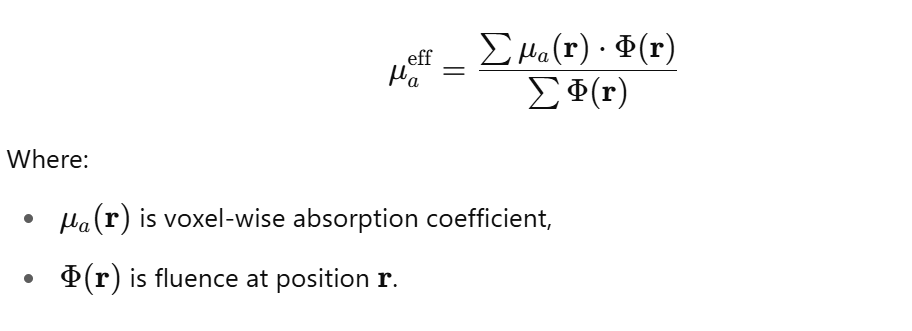

In [15]:
import numpy as np

# Extract 3D fluence (sum over time if needed)
fluence = np.squeeze(res['flux'])  # shape: (X, Y, Z) or (X, Y, Z, T)
if fluence.ndim == 4:
    fluence = np.sum(fluence, axis=-1)  # sum over time dimension

# Convert μa from cm⁻¹ to mm⁻¹ if needed (unitinmm = 1)
mu_a_mm = np.array(mu_a)   # Convert to mm⁻¹
mu_a_map = np.zeros_like(fluence)

# Assign μa values to each tissue label in volume
for i in range(1, 5):  # tissue labels: 1–4
    mu_a_map[vol == i] = mu_a_mm[i - 1]

# Compute absorbed energy in each voxel
absorbed = mu_a_map * fluence  # units: 1/mm × [fluence] → absorbed energy density

# Compute fluence-weighted effective μa
mu_a_eff_mm = np.sum(absorbed) / np.sum(fluence)  # units: 1/mm

# Convert back to cm⁻¹ for reporting
mu_a_eff_cm = mu_a_eff_mm * 10

print(f"Effective μa (fluence-weighted): {mu_a_eff_cm:.5f} 1/cm")


Effective μa (fluence-weighted): 0.09387 1/cm


In [16]:
ppath = detphoton['ppath']  # shape: (N, 4)
# transfer into cm:
mu_a_cm  = mu_a * 10
ppath_cm = ppath / 10.0
mu_a_eff_path = np.sum(ppath_cm * mu_a_cm) / np.sum(ppath_cm)
print(f"Effective μa: {mu_a_eff_path:.5f} 1/cm")

Effective μa: 0.09025 1/cm


### Simulation Results

<ipython-input-17-6de7787ee31b>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(res['flux'][50,:, :, 0]))


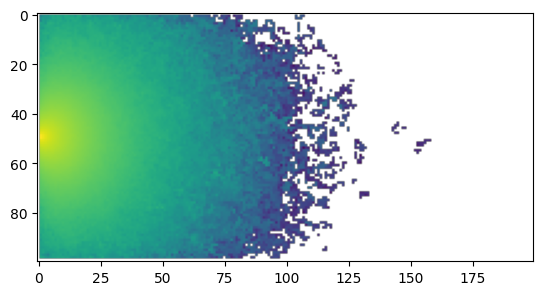

In [17]:
plt.imshow(np.log10(res['flux'][50,:, :, 0]))
plt.show()

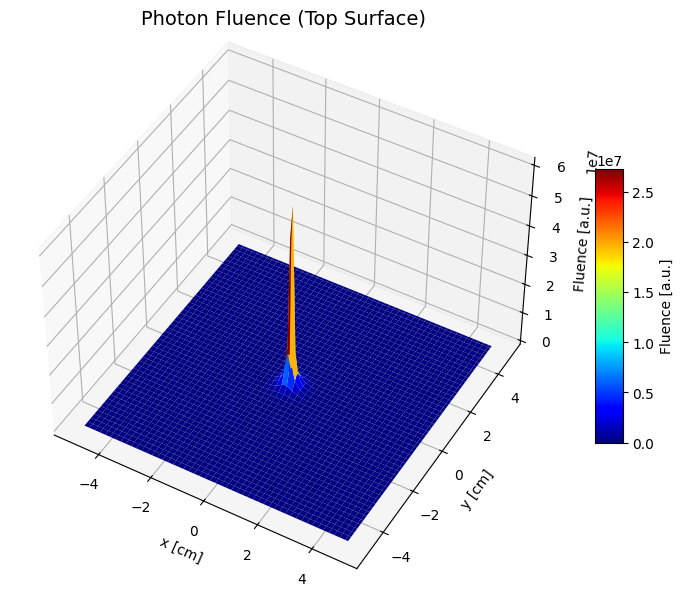

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sum over time bins to get total fluence
fluence_sum = np.sum(res['flux'], axis=-1)  # shape: (nx, ny, nz)

# Extract fluence at z = 1 mm (usually first tissue layer)
fluence_top = fluence_sum[:, :, 1]  # shape: (nx, ny)

# Get grid size
nx, ny = fluence_top.shape

# Spatial coordinates in cm (assuming 1 mm voxel → 0.1 cm)
unit_cm = 0.1
x = (np.arange(nx) - nx // 2) * unit_cm
y = (np.arange(ny) - ny // 2) * unit_cm
X, Y = np.meshgrid(x, y)

# Plot surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, fluence_top.T, cmap='jet', edgecolor='none')

ax.set_title('Photon Fluence (Top Surface)', fontsize=14)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('Fluence [a.u.]')
fig.colorbar(surf, shrink=0.5, aspect=10, label='Fluence [a.u.]')

# Optional: set top-down or angled view
# ax.view_init(elev=90, azim=-90)  # for top-down
ax.view_init(elev=45, azim=-60)    # angled 3D

plt.tight_layout()
plt.show()


65.0 50.0 5.0


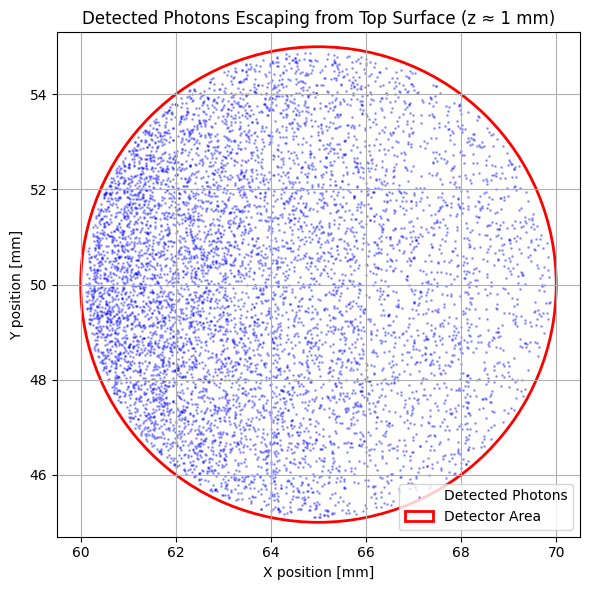

In [19]:

# [65, 50, 1, 5]

# Extract photon exit data
exit_pos = res['detp']['p']  # shape: (N, 3)
exit_dir = res['detp']['v']  # shape: (N, 3)

# Filter for photons exiting at top surface and going upward
z_top = 1.0  # mm
mask_top = (np.abs(exit_pos[:, 2] - z_top) < 0.5) & (exit_dir[:, 2] < 0)

# Get x, y positions
top_x = exit_pos[mask_top, 0]
top_y = exit_pos[mask_top, 1]

# Plot detected photons
plt.figure(figsize=(6, 6))
plt.scatter(top_x, top_y, s=1, alpha=0.3, color='blue', label='Detected Photons')

# Detector configuration (from cfg['detpos'])
det_x, det_y, _, det_r = cfg['detpos'][0]
print(det_x, det_y, det_r)

# Draw red circle for detector area
circle = plt.Circle((det_x, det_y), det_r, color='red', fill=False, linewidth=2, label='Detector Area')
plt.gca().add_patch(circle)

plt.xlabel("X position [mm]")
plt.ylabel("Y position [mm]")
plt.title("Detected Photons Escaping from Top Surface (z ≈ 1 mm)")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


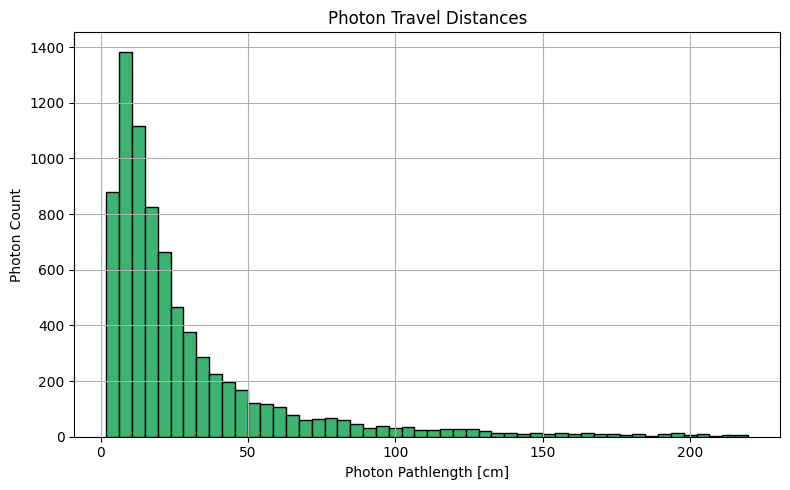

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Extract partial pathlengths per detected photon (shape: N_photons x N_layers)
ppath = res['detp']['ppath']  # in mm

# Compute total pathlength per photon (in mm)
pathlengths_mm = np.sum(ppath, axis=1)  # shape: (N_photons,)

# Optional: convert to cm
pathlengths_cm = pathlengths_mm / 10.0

plt.figure(figsize=(8, 5))
plt.hist(pathlengths_cm, bins=50, color='mediumseagreen', edgecolor='k')
plt.xlabel("Photon Pathlength [cm]")
plt.ylabel("Photon Count")
plt.title("Photon Travel Distances")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
import importlib

### Baseline experiments

In [54]:
#  prop=np.array([[0, 0, 1, 1], [0.005, 1, 0.01, 1.37]])) : [μa=0.005, μs=1, g=0.01, n=1.37]

vol = np.ones([100, 100, 200], dtype='uint8')
vol[:, :, 0:1] = 0    # Medium 1: Skin (2 mm, z=0 to 1)
vol[:, :, 1:2] = 1    # Medium 1: Skin (2 mm, z=0 to 1)
vol[:, :, 2:5] = 2    # Medium 2: Scalp (3 mm, z=2 to 4)
vol[:, :, 5:14] = 3   # Medium 3: Skull (7 mm, z=5 to 11)
#vol[:, :, 12:14] = 4  # Medium 4: CSF (2 mm, z=12 to 13)
vol[:, :, 14:200] = 4 # Medium 5: Brain (186 mm, z=14 to 199)

# define the boundary:
vol[:, :, 0] = 0
vol[:, :, 199] = 0
vol[0, :, :] = 0
vol[99, :, :] = 0
vol[:, 0, :] = 0
vol[:, 99, :] = 0

# set n =1.37 for tissue
prop_bl = np.array([
    [0.0, 0.0, 1.0, 1.0],
    [0.02, mu_s[0], g_list[0], 1.37],   # material 1 : skin
    [0.02, mu_s[1], g_list[1], 1.37],    # material 2 : scalp
    [0.02, mu_s[2], g_list[2], 1.40],   # material 3 : skull
    [0.02, mu_s[3], g_list[3], 1.36],      # material 4 : brain
])

import pmcx
import numpy as np

# Simulation configuration
cfg_bl = {
    'nphoton': 1000000,  # 1M photons
    'vol': vol, # 100x100x100 mm in size.
    'tstart': 0, # start time
    'tend': 1e-8, # end time
    'tstep': 1e-8, # step size
    'srcpos': [50, 50, 1],
    'srcdir': [0, 0, 1],  # Pointing toward z=1
    'prop': prop_bl,  # mediums.
    'detpos': [[65, 50, 0, 5]],  # Single detector radius 5 mm, 1.5 cm far away from the light source.
    'savedetflag': 'dpxsvmw',  # Save detector ID, exit position, exit direction, partial path lengths
    'unitinmm': 1,
    'autopilot': 1,
    'debuglevel': 'DP', # Debug detected photons
    'srctype': 'gaussian',      # Gaussian spatial profile
    'waist': 1.0,                # Beam waist (1/e^2 radius) in mm
}

cfg_bl['issaveref']=1
cfg_bl['issavedet']=1
cfg_bl['issrcfrom0']=1
cfg_bl['maxdetphoton']=1000000

# Run the simulation
res_bl = pmcx.mcxlab(cfg_bl)
print(res_bl['stat'])
print("Result keys:", list(res_bl.keys()))
print('detp keys:', res_bl['detp'].keys())

nphoton: 1e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
{'runtime': 518, 'nphoton': 1000000, 'energytot': 1000000.0, 'energyabs': 424879.86432691605, 'normalizer': 100.0, 'unitinmm': 1.0, 'workload': [6912.0]}
Result keys: ['detp', 'dref', 'flux', 'stat']
detp keys: dict_keys(['detid', 'nscat', 'ppath', 'mom', 'p', 'v', 'w0', 'prop', 'unitinmm', 'data'])


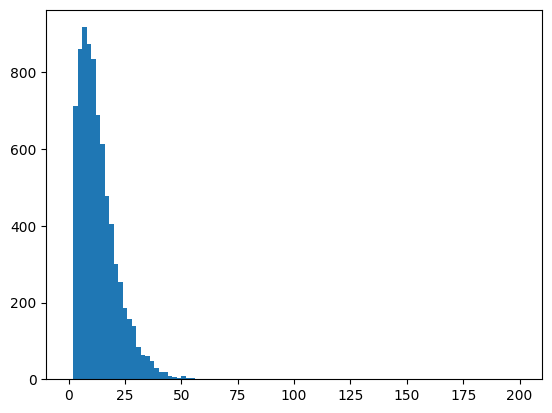

In [55]:
plt.hist(res_bl['detp']['ppath'][:,0], bins=100, range=[0,200]); # path in first layer!

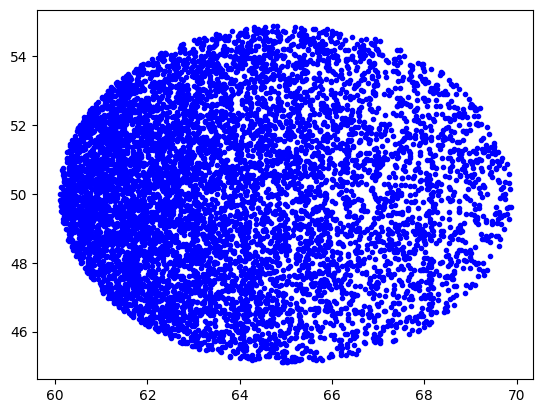

In [56]:
plt.scatter(res_bl['detp']['p'][res_bl['detp']['detid']==1,0], res_bl['detp']['p'][res_bl['detp']['detid']==1,1],
            marker='.',color='blue');

<ipython-input-57-3b936403b2e6>:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(res_bl['dref'][:, :, 0]))


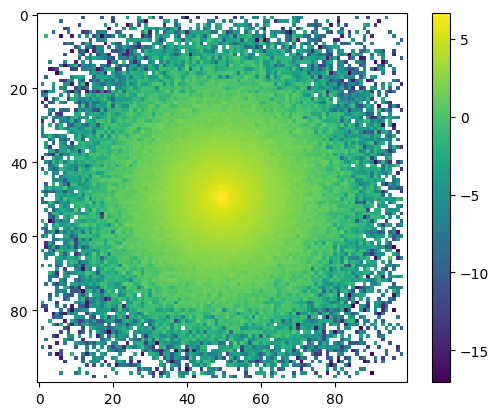

In [57]:
#print(np.log10(res['dref'][:, :, 0]).shape)
plt.imshow(np.log10(res_bl['dref'][:, :, 0]))
plt.colorbar()
plt.show()

<ipython-input-58-21d6f31a87ca>:4: RuntimeWarning: divide by zero encountered in log10
  im0 = axes[0].imshow(np.log10(res_bl['flux'][50, :, :, 0]), cmap='hot')
<ipython-input-58-21d6f31a87ca>:9: RuntimeWarning: divide by zero encountered in log10
  im1 = axes[1].imshow(np.log10(res['flux'][50, :, :, 0]), cmap='hot')


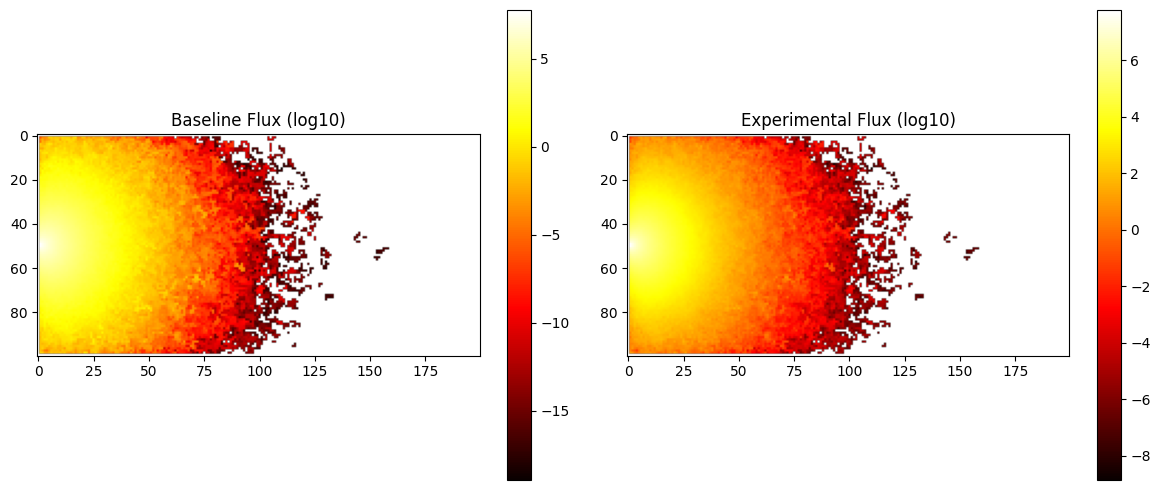

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: res_bl
im0 = axes[0].imshow(np.log10(res_bl['flux'][50, :, :, 0]), cmap='hot')
axes[0].set_title("Baseline Flux (log10)")
fig.colorbar(im0, ax=axes[0])

# Right: res
im1 = axes[1].imshow(np.log10(res['flux'][50, :, :, 0]), cmap='hot')
axes[1].set_title("Experimental Flux (log10)")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

<ipython-input-59-e8defba07912>:4: RuntimeWarning: divide by zero encountered in log10
  im0 = axes[0].imshow(np.log10(res['flux'][:, :, 1, 0]), cmap='hot')
<ipython-input-59-e8defba07912>:9: RuntimeWarning: divide by zero encountered in log10
  im1 = axes[1].imshow(np.log10(res_bl['flux'][:, :, 1, 0]), cmap='hot')


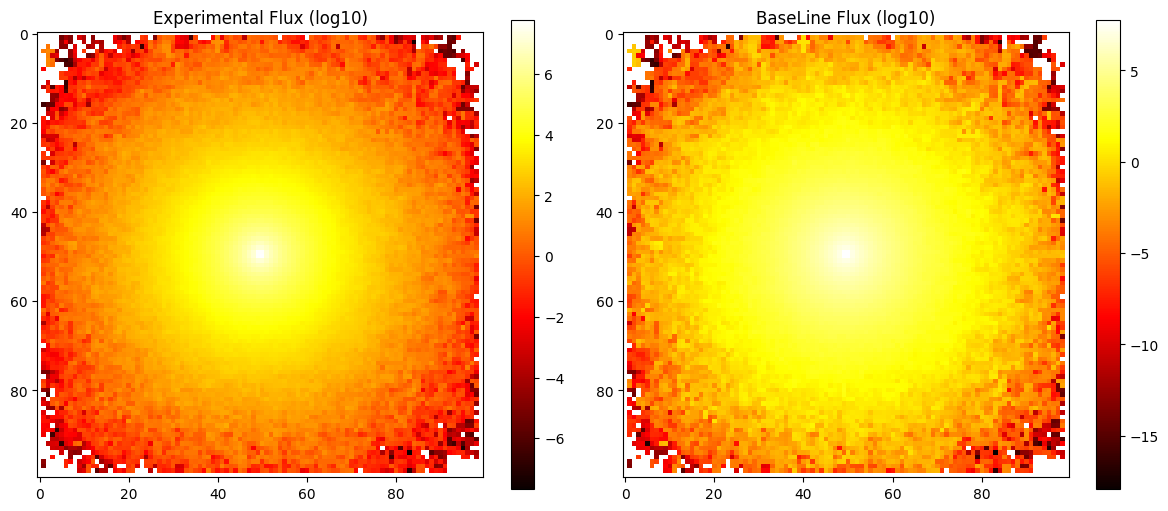

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: res_bl['flux']
im0 = axes[0].imshow(np.log10(res['flux'][:, :, 1, 0]), cmap='hot')
axes[0].set_title("Experimental Flux (log10)")
fig.colorbar(im0, ax=axes[0])

# Right plot: res['flux']
im1 = axes[1].imshow(np.log10(res_bl['flux'][:, :, 1, 0]), cmap='hot')
axes[1].set_title("BaseLine Flux (log10)")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

<ipython-input-60-06c1877bcfc0>:3: RuntimeWarning: divide by zero encountered in log10
  im0 = axes[0].imshow(np.log10(res['dref'][:, :, 0]), cmap='hot')
<ipython-input-60-06c1877bcfc0>:8: RuntimeWarning: divide by zero encountered in log10
  im1 = axes[1].imshow(np.log10(res_bl['dref'][:, :, 0]), cmap='hot')


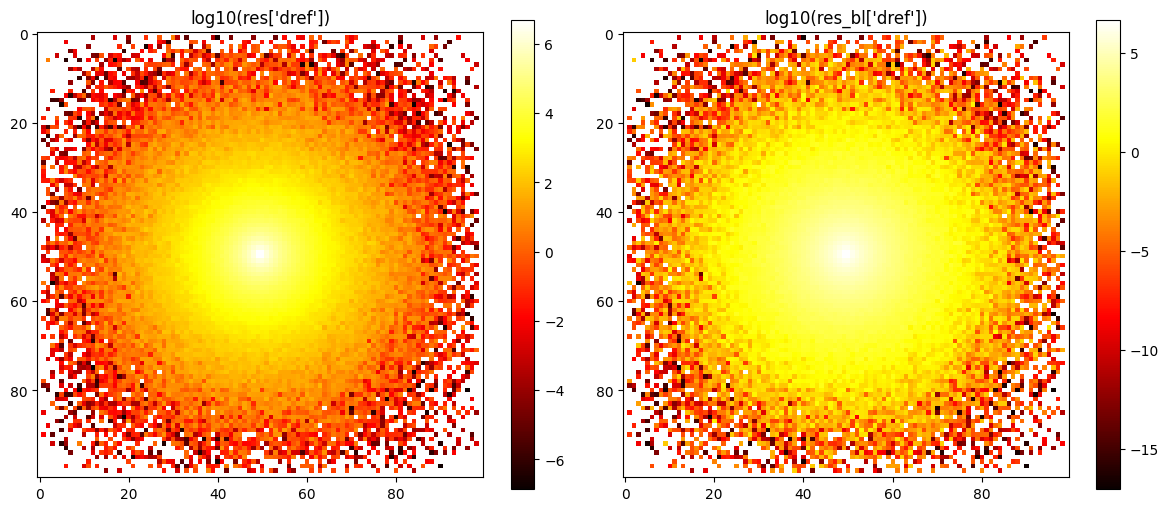

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(np.log10(res['dref'][:, :, 0]), cmap='hot')
axes[0].set_title("log10(res['dref'])")
fig.colorbar(im0, ax=axes[0])

# Right: res_bl['dref']
im1 = axes[1].imshow(np.log10(res_bl['dref'][:, :, 0]), cmap='hot')
axes[1].set_title("log10(res_bl['dref'])")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

65.0 50.0 5.0


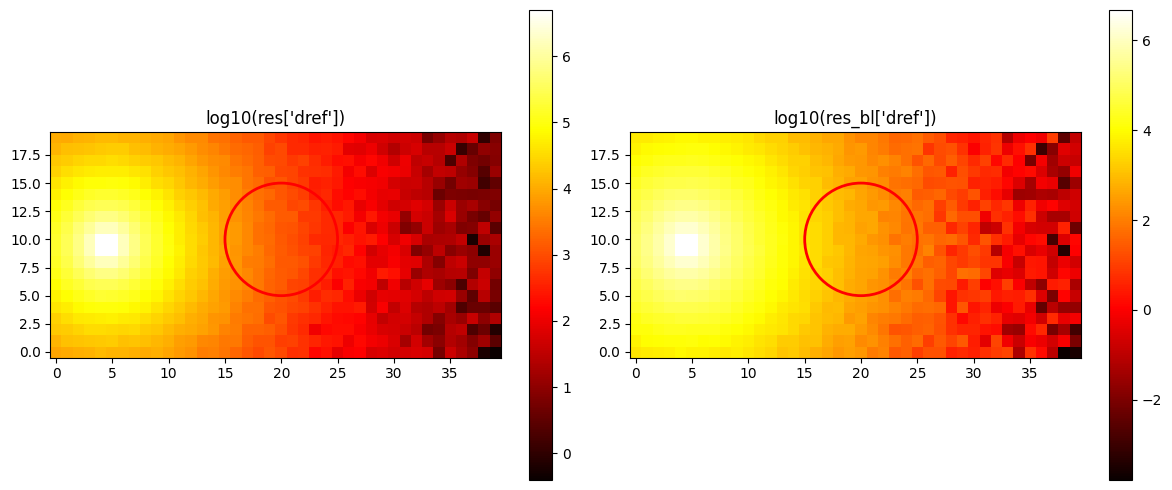

In [61]:
# Extract detector info
det_x, det_y, _, det_r = cfg['detpos'][0]
print(det_x, det_y, det_r) # 65, 50, 5

# Cropping bounds
x_start, x_end = 45, 85
y_start, y_end = 40, 60

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: res['dref']
im0 = axes[0].imshow(np.log10(res['dref'][y_start:y_end, x_start:x_end, 0]), cmap='hot', origin='lower')
axes[0].set_title("log10(res['dref'])")
fig.colorbar(im0, ax=axes[0])
circle0 = plt.Circle((det_x - x_start, det_y - y_start), det_r, color='red', fill=False, linewidth=2)
axes[0].add_patch(circle0)

# Plot 2: res_bl['dref']
im1 = axes[1].imshow(np.log10(res_bl['dref'][y_start:y_end, x_start:x_end, 0]), cmap='hot', origin='lower')
axes[1].set_title("log10(res_bl['dref'])")
fig.colorbar(im1, ax=axes[1])
circle1 = plt.Circle((det_x - x_start, det_y - y_start), det_r, color='red', fill=False, linewidth=2)
axes[1].add_patch(circle1)

plt.tight_layout()
plt.show()


In [62]:
# Get detector info
det_x, det_y, _, det_r = cfg['detpos'][0]  # center (x, y), radius (in voxel units)

# Get the 2D dref array (assuming shape: [Y, X, 1])
dref = res['dref'][:, :, 0].squeeze(2)  # shape: (Ny, Nx)
ny, nx = dref.shape
Y, X = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')  # shape: (ny, nx)
mask = (X - det_x) ** 2 + (Y - det_y) ** 2 <= det_r ** 2
dref_sum = np.sum(dref[mask])
print("Sum of dref in detector region:", dref_sum)

Sum of dref in detector region: 169713.56


In [63]:
# Get detector info
det_x, det_y, _, det_r = cfg['detpos'][0]  # center (x, y), radius (in voxel units)
dref = res_bl['dref'][:, :, 0].squeeze(2)  # shape: (Ny, Nx)
ny, nx = dref.shape
Y, X = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')  # shape: (ny, nx)
mask = (X - det_x) ** 2 + (Y - det_y) ** 2 <= det_r ** 2
dref_sum = np.sum(dref[mask])
print("Sum of dref in detector region:", dref_sum)

Sum of dref in detector region: 65029.42


In [70]:
ppath = res_bl['detp']['ppath']
mu_a = np.array([0.02, 0.02, 0.02, 0.02])
mu_a_cm  = mu_a * 10
ppath_cm = ppath / 10.0
mu_a_eff_path = np.sum(ppath_cm * mu_a_cm) / np.sum(ppath_cm)
print(f"Effective μa: {mu_a_eff_path:.5f} 1/cm")

Effective μa: 0.20000 1/cm


dict_keys(['detid', 'nscat', 'ppath', 'mom', 'p', 'v', 'w0', 'prop', 'unitinmm', 'data'])

### Reverse computation

> get delta ua



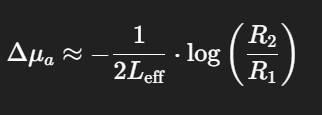

In [64]:
import math
def get_delta_ua(r1, r2, L_eff):
  return -(1/(2*L_eff))*(np.log(r2/r1))

In [80]:
# baseline
det_x, det_y, _, det_r = cfg['detpos'][0]
dref_bl = res_bl['dref'][:, :, 0].squeeze(2)
ny, nx = dref_bl.shape
Y, X = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')  # shape: (ny, nx)
mask = (X - det_x) ** 2 + (Y - det_y) ** 2 <= det_r ** 2
dref_sum_bl = np.sum(dref_bl[mask])

# detector
dref = res['dref'][:, :, 0].squeeze(2)  # shape: (Ny, Nx)
ny, nx = dref.shape
Y, X = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')  # shape: (ny, nx)
mask = (X - det_x) ** 2 + (Y - det_y) ** 2 <= det_r ** 2
dref_sum = np.sum(dref[mask])
print(dref_sum_bl, dref_sum)

#
Leff = np.sum(np.mean(res['detp']['ppath'], axis=1))
Leff_bl = np.sum(np.mean(res_bl['detp']['ppath'], axis=1))
print(Leff, Leff_bl)


# Baseline - experimental
print('ua_bl - ua_experiment=', get_delta_ua(dref_sum, dref_sum_bl, 30), '/mm')
print('ua_bl(gt) - ua_experiment(gt)=', 0.02 - 0.0009025, '/mm' )

65029.42 169713.56
568105.56 568105.56
ua_bl - ua_experiment= 0.015987871 /mm
ua_bl(gt) - ua_experiment(gt)= 0.0190975 /mm
